<a href="https://colab.research.google.com/github/edv1hu/test/blob/main/Crude_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crude Chartering Strategy for optimizing profits

In [1]:
# Import necessary libraries for data analythics and monte carlo simulation
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm.notebook import tqdm, trange
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


### Load images

Mounted at /content/drive


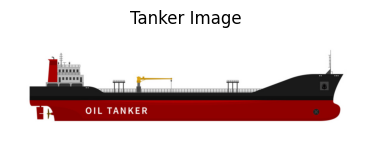

In [2]:
# Connect to google drive
from google.colab import drive
from pathlib import Path
from PIL import Image


drive.mount('/content/drive')

# Load icon 'barge-vector-icon.heic' from google drive (same folder)
# Path to your images
path_to_tanker_image = '/content/drive/My Drive/Skole/Crude_Project/tanker image.jpg'

# Load the images (example using OpenCV for images)
import cv2
from matplotlib import pyplot as plt

# Reading the images
tanker_image = cv2.imread(path_to_tanker_image)

# Check if images are loaded
if tanker_image is None:
    print("Failed to load tanker image. Check file path and format.")
else:
    tanker_image = cv2.cvtColor(tanker_image, cv2.COLOR_BGR2RGB)


# Proceed with displaying the images if they are loaded
if tanker_image is not None:
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(tanker_image)
    plt.title('Tanker Image')
    plt.axis('off')

    plt.show()



# Variables

In [3]:
time_horizon= 30 + 1  # years
discount_rate= 0.13  # 13%
operational_days_per_year= 365  # days

# The Vessel
aframax_capacity= 600  # 1000 bbl

# The Voyage
sailing_distance_suez= 7000  # nm
sailing_speed= 12  # knots
port_and_waiting_time= 2.5  # days

# Energy consumption
energy_consumption_sailing_laden= 8500 # kWh
energy_consumption_sailing_ballast= 6000  # kWh
energy_consumption_port= 3000  # kWh


# Calculations
sailing_time_one_way_suez= sailing_distance_suez/sailing_speed/24  # days, calculated variable but fixed
total_time_roundtrip_suez= 2* (sailing_time_one_way_suez + port_and_waiting_time)  # days, calculated variable but fixed
roundtrips_per_year= 360/total_time_roundtrip_suez        # trips, calculated variable but fixed
yearly_capacity= aframax_capacity * roundtrips_per_year # 1000 bbl, adjusted for correct representation
total_energy_consumption_roundtrip= 24* (sailing_time_one_way_suez* (energy_consumption_sailing_ballast + energy_consumption_sailing_laden)  + 2*energy_consumption_port*port_and_waiting_time)  # kWh/roundtrip, calculated variable but fixed


## Making a Dataframe

In [4]:
# Creating a dictionary where keys are column names and values are the variables
data = {
    'time_horizon': [time_horizon],  # years
    'discount_rate': discount_rate,  # 13%
    'operational_days_per_year': operational_days_per_year,  # days
    'aframax_capacity': aframax_capacity,  # 1000 bbl
    'yearly_capacity': yearly_capacity,  # adjusted for correct representation
    'sailing_distance_suez': sailing_distance_suez,  # nm
    'sailing_speed': sailing_speed,  # knots
    'port_and_waiting_time': port_and_waiting_time,  # days
    'sailing_time_one_way_suez': sailing_time_one_way_suez,  # days, calculated
    'total_time_roundtrip_suez': total_time_roundtrip_suez,  # days, calculated
    'roundtrips_per_year': roundtrips_per_year,  # trips, calculated
    'energy_consumption_sailing_laden': energy_consumption_sailing_laden,  # kWh
    'energy_consumption_sailing_ballast': energy_consumption_sailing_ballast,  # kWh
    'energy_consumption_port': energy_consumption_port,  # kWh
    'total_energy_consumption_roundtrip': total_energy_consumption_roundtrip # kWh/roundtrip, calculated variable but fixed]  # kWh/roundtrip, calculated
}

# Creating the DataFrame
df_variables = pd.DataFrame(data)

# Now the DataFrame's column names can be accessed as attributes.
df_variables.time_horizon  # This will return a Series of the time_horizon column

# Set the display format for float numbers
pd.options.display.float_format = '{:.2f}'.format

## Dataframe

In [5]:

df_variables.transpose()

,0
time_horizon,31.00
discount_rate,0.13
operational_days_per_year,365.00
aframax_capacity,600.00
yearly_capacity,4029.02
sailing_distance_suez,7000.00
sailing_speed,12.00
port_and_waiting_time,2.50
sailing_time_one_way_suez,24.31
total_time_roundtrip_suez,53.61


# Static Model

## Fixed Uncertainty Varibles

In [6]:
# Production
fixed_daily_production = 100  # bbl/day
fixed_yearly_production = 365 * fixed_daily_production  # bbl/year

# Spot and Time Charter Rates
fixed_spot  = 24800  # $/day
fixed_tc_1y = 23200  # $/day
fixed_tc_5y = 21400  # $/day

# Fuel Prices
fixed_bunker_price_vlsfo = 550  # $/bbl

# Port and other costs
fixed_port_and_additional_cost = 500000  # $/trip

# Port Waiting time
fixed_port_waiting_time = port_and_waiting_time  # days

# Crude Price
fixed_crude_price = 50/7.25  # $/bbl

### Making a DataFrame

In [7]:
data_uncertainty = {
    'fixed_yearly_production': fixed_yearly_production,  # bbl/year
    'fixed_spot': fixed_spot,
    'fixed_tc_1y': fixed_tc_1y,
    'fixed_tc_5y': fixed_tc_5y,
    'fixed_bunker_price_vlsfo': fixed_bunker_price_vlsfo,
    'fixed_port_and_additional_cost': fixed_port_and_additional_cost,
    'fixed_port_waiting_time': fixed_port_waiting_time,
    'fixed_crude_price': fixed_crude_price
}

df_uncertainty = pd.DataFrame(data_uncertainty, index=[0])

### DataFrame

In [8]:
df_uncertainty.transpose()

,0
fixed_yearly_production,36500.00
fixed_spot,24800.00
fixed_tc_1y,23200.00
fixed_tc_5y,21400.00
fixed_bunker_price_vlsfo,550.00
fixed_port_and_additional_cost,500000.00
fixed_port_waiting_time,2.50
fixed_crude_price,6.90


## Deterministic Production Profile
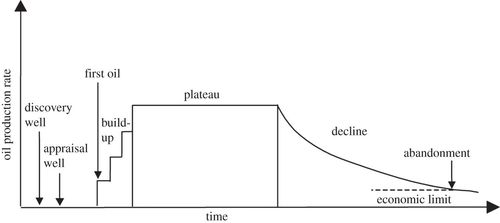

### Code

In [9]:
lifetime = time_horizon

# Constants for the production phases
ramp_up_years = 5
plateau_years = 15 - ramp_up_years  # From year 6 to 15
decline_years = lifetime - 15  # From year 16 to 30

# Ramp-Up Phase: Linear increase from 0 to 1 (100%) over the ramp-up period
ramp_up_profile = [0.2 * year for year in range(ramp_up_years)]

# Plateau Phase: 1 (100%) production capacity
plateau_profile = [1 for _ in range(plateau_years)]

# Decline Phase: Exponential decline starting at 1 (100%) and reducing each year
decline_rate = 0.07  # Assuming a 7% decline rate per year for simplicity
decline_profile = [1 * ((1 - decline_rate) ** year) for year in range(decline_years)]

# Combine all phases into one production profile
production_profile = ramp_up_profile + plateau_profile + decline_profile

# Ensure the profile has 30 years of data
production_profile = production_profile[:lifetime]

def plot_production_profile(prod_profile = production_profile):
  """Plot the production profile."""
  # Define colors for different phases
  colors = ['skyblue' if year < ramp_up_years else 'lightgreen' if year-1 < ramp_up_years + plateau_years else 'salmon'
            for year in range(lifetime)]

  # Create the bar plot
  plt.figure(figsize=(14, 7))
  barplot = sns.barplot(x=list(range(lifetime)), y=prod_profile, palette=colors)
  plt.xlabel('Year')
  plt.ylabel('Production as a Proportion of Max Capacity')
  plt.title('Production Profile')

  # Add legend manually for the three phases
  from matplotlib.patches import Patch
  legend_elements = [Patch(facecolor='skyblue', label='Ramp Up Phase'),
                    Patch(facecolor='lightgreen', label='Plateau Phase'),
                    Patch(facecolor='salmon', label='Decline Phase')]
  plt.legend(handles=legend_elements, loc='upper right')

  # Show the plot


### Output

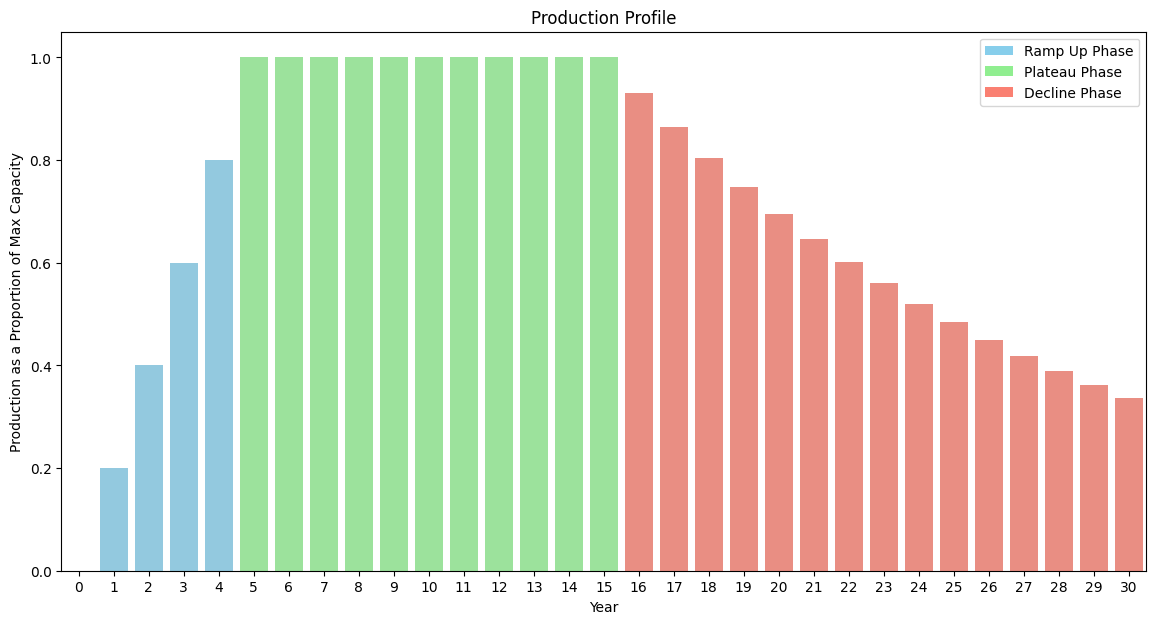

In [10]:
# Variable = production_profile
plot_production_profile()

## The Model

### Vessel Class

In [11]:
class Vessel:
    def __init__(self, daily_rate, contract_duration, contract_end_year, fuel_type = "VLSFO"):
        self.daily_rate = daily_rate
        self.contract_duration = contract_duration
        self.contract_end_year = contract_end_year
        self.fuel_type = fuel_type

        self.fuel_consumption_yr = 0
        self.co2_emissions = 0

        # Specific Fuel Consumption [g/kWh]
        self.sfc = {'VLSFO': 170,
                    'HSFO' : 179,
                    'LNG'  : 150,
                    'Methanol' : 381} # Methanol(LNG)

        # CO2 emissions per ton fuel [ton emission/ton fuel]
        self.co2_per_ton_fuel = {'VLSFO': 3.2,
                    'HSFO' : 3.2,
                    'LNG'  : 2.8,
                    'Methanol' : 1.375} # Methanol(LNG)

    def update_emissions(self,total_energy_consumption_roundtrip, roundtrips_per_year):

        self.fuel_consumption_yr = self.sfc[self.fuel_type] * total_energy_consumption_roundtrip * roundtrips_per_year / 1e6
        self.co2_emissions = self.co2_per_ton_fuel[self.fuel_type] * self.fuel_consumption_yr



### Static Model Class

In [12]:


class StaticModel:
    def __init__(self, df_variables, df_uncertainty, production_profile):
        # Extract all columns from df_variables and df_uncertainty as class variables
        for column_name in df_variables.columns:
            setattr(self, column_name, df_variables[column_name].values[0])

        for column_name in df_uncertainty.columns:
            setattr(self, column_name, df_uncertainty[column_name].values[0])

        self.production_profile = np.array(production_profile)
        self.production = np.array(production_profile) * self.fixed_yearly_production



        # Initialize an empty list to store vessels on contract
        self.vessels = []
        self.spot_voyages = np.zeros(self.time_horizon)
        self.tc_vessels = np.zeros(self.time_horizon)
        # Fuel consumption per roundtrip/spot voyage
        self.spot_fuel_consumption_vlsfo = 170 * self.total_energy_consumption_roundtrip / 1e6

        # New 5year Time Charter history
        self.new_tc_5y_history = np.zeros(self.time_horizon)
        self.end_tc_5y_history = np.zeros(self.time_horizon)


        # Costs and Revenue
        self.fuel_costs = np.zeros(self.time_horizon)
        self.chartering_costs = np.zeros(self.time_horizon)
        self.spot_costs = np.zeros(self.time_horizon)
        self.port_costs = np.zeros(self.time_horizon)
        self.revenue = np.zeros(self.time_horizon)
        self.profit = np.zeros(self.time_horizon)

        self.profit_npv = 0

        # Cargo Quantity Transported/sold
        self.tc_cargoQTY = np.zeros(self.time_horizon)
        self.cargoQTY = np.zeros(self.time_horizon)



    def sign_tc5yr_vessel(self, year):
        vessel = Vessel(self.fixed_tc_5y, 5, year + 5)
        self.vessels.append(vessel)
        vessel.update_emissions(total_energy_consumption_roundtrip, roundtrips_per_year)

        self.tc_vessels[year+1] += 1
        if (year+5) < self.time_horizon:
            self.end_tc_5y_history[year+5] += 1

        return vessel

    def update_vessels(self, year):
        # Update the vessels
        yr = int(year)
        for vessel in self.vessels:
            if (year>0) & (vessel.contract_end_year == (yr-1)):
                self.vessels.remove(vessel)


        self.tc_vessels[year] = len(self.vessels)

    def calculate_revenue(self, year):
        # Calculate the revenue
        revenue = self.cargoQTY[year] * self.fixed_crude_price
        self.revenue[year] = revenue

        # Return

    def calculate_time_charter_cost(self, year):
        # Calculate the chartering cost
        chartering_cost = 0
        for vessel in self.vessels:
            chartering_cost += 365*vessel.daily_rate

        self.chartering_costs[year] = chartering_cost

        # Return the chartering cost
        return chartering_cost

    def calculate_spot(self, year):
        i = year
        # Calculate the spot cost
        spot_cost = 0
        spot_voyages = 0
        spot_cargoQTY = 0

        # Calculate the total cargo quantity
        nr_tc_vessels = len(self.vessels)
        tc_cargoQTY = nr_tc_vessels * self.aframax_capacity * self.roundtrips_per_year

        if tc_cargoQTY < self.production[i]:
            spot_voyages = round((self.production[i] - tc_cargoQTY) / self.aframax_capacity)
            spot_cargoQTY = spot_voyages * self.aframax_capacity
            spot_cost = spot_voyages * self.fixed_spot * self.total_time_roundtrip_suez

        self.spot_voyages[year] = spot_voyages
        self.spot_costs[year] = spot_cost
        self.tc_cargoQTY[year] = tc_cargoQTY
        self.cargoQTY[year]  = min(spot_cargoQTY + tc_cargoQTY , self.production[i])

        # Return the spot cost
        return spot_voyages, spot_cargoQTY, spot_cost


    def calculate_fuel_cost(self, year):
        # Calculate the fuel cost
        fuel_cost = 0

        for vessel in self.vessels:
            fuel_cost += vessel.fuel_consumption_yr * self.fixed_bunker_price_vlsfo

        fuel_cost += self.spot_voyages[year] * self.fixed_bunker_price_vlsfo * self.spot_fuel_consumption_vlsfo
        self.fuel_costs[year] = fuel_cost

        # Return the fuel cost
        return fuel_cost

    def calculate_port_cost(self, year):

        # Calculate total number of roundtrips
        total_roundtrips = len(self.vessels) * self.roundtrips_per_year + self.spot_voyages[year]
        # Calculate the port cost
        port_cost = total_roundtrips * (self.fixed_port_and_additional_cost)

        self.port_costs[year] = port_cost

        # Return the port cost
        return port_cost


    def calculate_costs(self, year):

        self.calculate_fuel_cost(year)
        self.calculate_time_charter_cost(year)
        self.calculate_spot(year)
        self.calculate_port_cost(year)

        # Calculate the total cost
        total_cost = self.fuel_costs[year] + self.chartering_costs[year] + self.spot_costs[year] + self.port_costs[year]

        # Return the total cost
        return total_cost

    def calculate_revenue(self, year):

        # Calculate the revenue
        revenue = self.cargoQTY[year] * self.fixed_crude_price * 1000

        self.revenue[year] = revenue

        # Return the revenue
        return revenue

    def calculate_profit(self, year):
        # Calculate the profit
        profit = self.revenue[year] - self.calculate_costs(year)

        self.profit[year] = profit

        profit_npv_yr = profit / (1 + self.discount_rate) ** year

        self.profit_npv += profit_npv_yr

        # Return the profit
        return profit

    def predicted_production(self, year):
        """
        Predicts next year's production based on the current year's production and production profile.

        :param year: Current year (0-indexed).
        :return: Predicted production for the next year.
        """

        # For year 0, use fixed_yearly_production
        if year == 0:
            return self.fixed_yearly_production * self.production_profile[year + 1]

        # For subsequent years, estimate based on last year's production
        else:
            # Make sure not to go out of bounds for the production_profile array
            if year + 1 < len(self.production_profile):
                estimated_capacity = self.production[year] / (self.production_profile[year])
                return estimated_capacity * (self.production_profile[year + 1])
            else:
                # Handle the case when year + 1 is out of the production_profile array bounds
                # You can return some default value or handle it as per your logic
                return 0  # or some other appropriate value

    def run_case(self, decision_rule):
        # Initialize NPV values
        profit_npv = 0
        cost_per_cargo_npv = 0

        # Loop through each year
        for i in trange(self.time_horizon):
            # Update the vessels for the current year
            self.update_vessels(i)

            # Calculate costs and revenue
            self.calculate_costs(i)
            self.calculate_revenue(i)
            profit = self.calculate_profit(i)

            # Calculate Net Present Value (NPV) of profit and cost per cargo
            profit_npv += profit / (1 + self.discount_rate) ** i
            if self.cargoQTY[i] > 0:
                cost_per_cargo_npv += (self.calculate_costs(i) / self.cargoQTY[i]) / (1 + self.discount_rate) ** i
            else:
                cost_per_cargo_npv += 0

            # Update the profit and chartering costs for the current year
            self.profit[i] = profit
            self.chartering_costs[i] = self.calculate_time_charter_cost(i)

            # New TC-vessels is signed a year in advance
            # Use the decision rule to decide when to sign new contracts
            for j in range(decision_rule(self, i)):
                self.sign_tc5yr_vessel(i)
                self.new_tc_5y_history[i] += 1

        return profit_npv, cost_per_cargo_npv


    def display_info(self):
        # DataFrame
        df = pd.DataFrame({'Year': list(range(self.time_horizon)),
                           'Production': self.production,
                           'Cargo': self.cargoQTY,
                           'TC Cargo Quantity': self.tc_cargoQTY,
                           'New TC Vessels': self.new_tc_5y_history,
                           'End TC Contracts (end of year)':self.end_tc_5y_history,
                           'Spot Voyages': self.spot_voyages,
                           'TC Vessels': self.tc_vessels,
                           'Fuel Cost': self.fuel_costs,
                           'Time Charter Cost': self.chartering_costs,
                           'Spot Cost': self.spot_costs,
                           'Port Cost': self.port_costs,
                           'Revenue': self.revenue,
                           'Profit': self.profit})

        # Set display format for floating point numbers
        pd.options.display.float_format = '{:,.0f}'.format
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)

        # Display the data
        display(df.transpose())




## Cases

### Only SPOT

In [13]:
def decision_rule_spot(case_model, year):
    return 0


spot_case = StaticModel(df_variables, df_uncertainty, production_profile)
spot_case.run_case(decision_rule_spot)

  0%|          | 0/31 [00:00<?, ?it/s]

(500048606.20462096, 33281.37430630959)

### 50% TC Case

In [14]:
def decision_rule_tc_cargo(case_model, year):
    """
    Decision rule to determine the number of new time charter contracts to sign in a given year.

    :param case_model: Instance of StaticModel class.
    :param year: Current year (0-indexed).
    :param tc_cargo_percentage: Desired percentage of cargo to be transported by time charter vessels.
    :return: Number of new time charter contracts to sign.
    """
    # Desired percentage of cargo to be transported by time charter vessels
    tc_cargo_percentage = 0.5


    # Predict next year's production
    predicted_production_next_year = case_model.predicted_production(year)

    # Calculate the desired TC cargo quantity for the next year
    desired_tc_cargo_qty = predicted_production_next_year * tc_cargo_percentage

    # Calculate the current TC cargo capacity
    nr_tc_vessels = len(case_model.vessels) - case_model.end_tc_5y_history[year]

    current_tc_cargo_capacity = nr_tc_vessels * case_model.aframax_capacity * case_model.roundtrips_per_year

    # Calculate the additional TC capacity needed
    additional_tc_capacity_needed = desired_tc_cargo_qty - current_tc_cargo_capacity

    # Determine the number of vessels to sign based on the capacity of each vessel
    vessel_capacity_per_year = case_model.aframax_capacity * case_model.roundtrips_per_year
    number_of_vessels_to_sign = round(additional_tc_capacity_needed / vessel_capacity_per_year)  # Ceiling division

    return max(0, number_of_vessels_to_sign)  # Ensure the result is not negative

In [15]:
case1 = StaticModel(df_variables, df_uncertainty, production_profile)
#case1.__dict__
case1.run_case(decision_rule_tc_cargo)
#case1.display_info()

  0%|          | 0/31 [00:00<?, ?it/s]

(532060597.67925954, 32047.337215896157)

# Uncertanity Model

## Uncertainy Varables

### Production

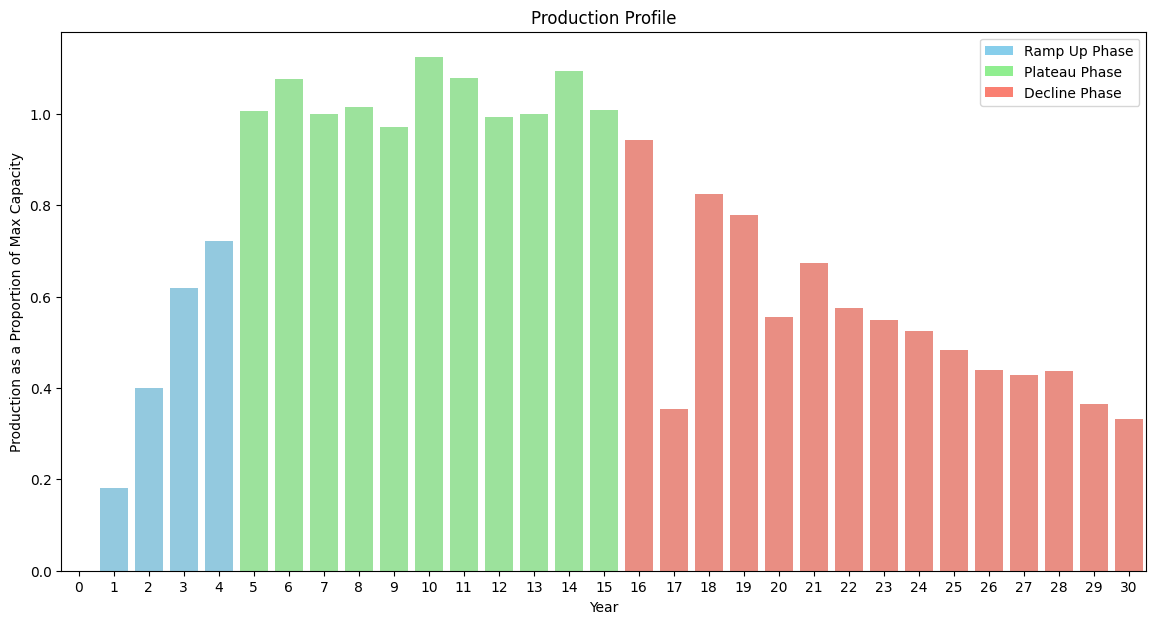

In [16]:
expected_production_profile = production_profile.copy()

def apply_uncertainty_to_production_profile(production_profile, fluctuation_rate=0.05, event_probability=0.05, lower=0.0, mode=1, upper=1.2):
    """
    Apply a combination of yearly fluctuations and unexpected events to the production profile.

    :param production_profile: List of production values.
    :param fluctuation_rate: Maximum fluctuation rate as a proportion of production.
    :param event_probability: Probability of an unexpected event occurring in a given year.
    :param lower: The lower limit for production change (0.0 for shutdown).
    :param mode: The value at which the peak of the distribution occurs.
    :param upper: The upper limit for production change (1.2 for 20% increase).
    :return: Adjusted production profile with fluctuations and unexpected events.
    """
    adjusted_profile = []
    for p in production_profile:
        if np.random.rand() < event_probability:  # Chance to apply an unexpected event
            change_factor = np.random.triangular(lower, mode, upper)
            adjusted_value = p * change_factor
            if adjusted_value < 0.2 * p:
                adjusted_value = 0
            adjusted_profile.append(adjusted_value)
        else:  # Apply yearly fluctuation
            fluctuated_value = max(0, p + np.random.normal(0, fluctuation_rate * p))
            adjusted_profile.append(fluctuated_value)
    return adjusted_profile

# Applying uncertainty to the production profile
uncertain_production_profile = apply_uncertainty_to_production_profile(production_profile)

# Plotting the uncertain production profile
plot_production_profile(uncertain_production_profile)





,Production
count,3000.00
mean,0.98
std,0.11
min,0.00
25%,0.96
50%,1.00
75%,1.03
max,1.21


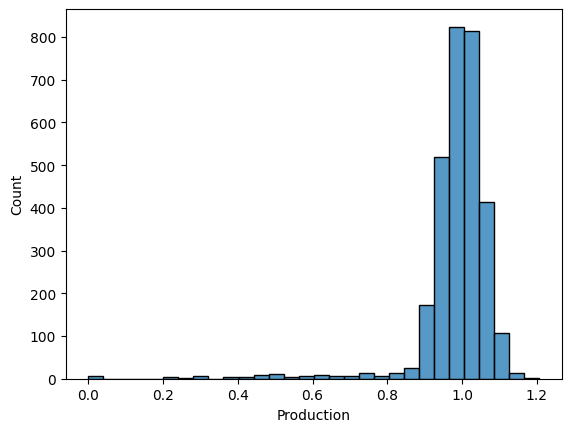

In [39]:
dummy = np.ones(31)

production_samples = []
for _ in range(100):
    # Apply uncertainty and remove the first element (index 0) before appending
    sample_with_uncertainty = apply_uncertainty_to_production_profile(dummy)[1:]
    production_samples.append(sample_with_uncertainty)

# Flatten the list of lists into a single list
flat_production_samples = [sample for sublist in production_samples for sample in sublist]

# Convert to DataFrame
flat_production_samples_df = pd.DataFrame({'Production': flat_production_samples})

# Display summary statistics and histogram
display(flat_production_samples_df.describe())

sns.histplot(flat_production_samples_df['Production'], bins=30)
plt.show()




##### Simulations and Visualization

In [18]:
import altair as alt
import pandas as pd

# Number of simulations
num_simulations = 2000

# Collect all profiles in a list first
profiles_list = []

# Running the Monte Carlo simulations
for sim in range(num_simulations):
    profile = apply_uncertainty_to_production_profile(production_profile)
    profiles_list.append(profile)

# Convert the list of profiles to a DataFrame
all_profiles = pd.DataFrame(profiles_list).transpose()

# You can then proceed with the plotting as before


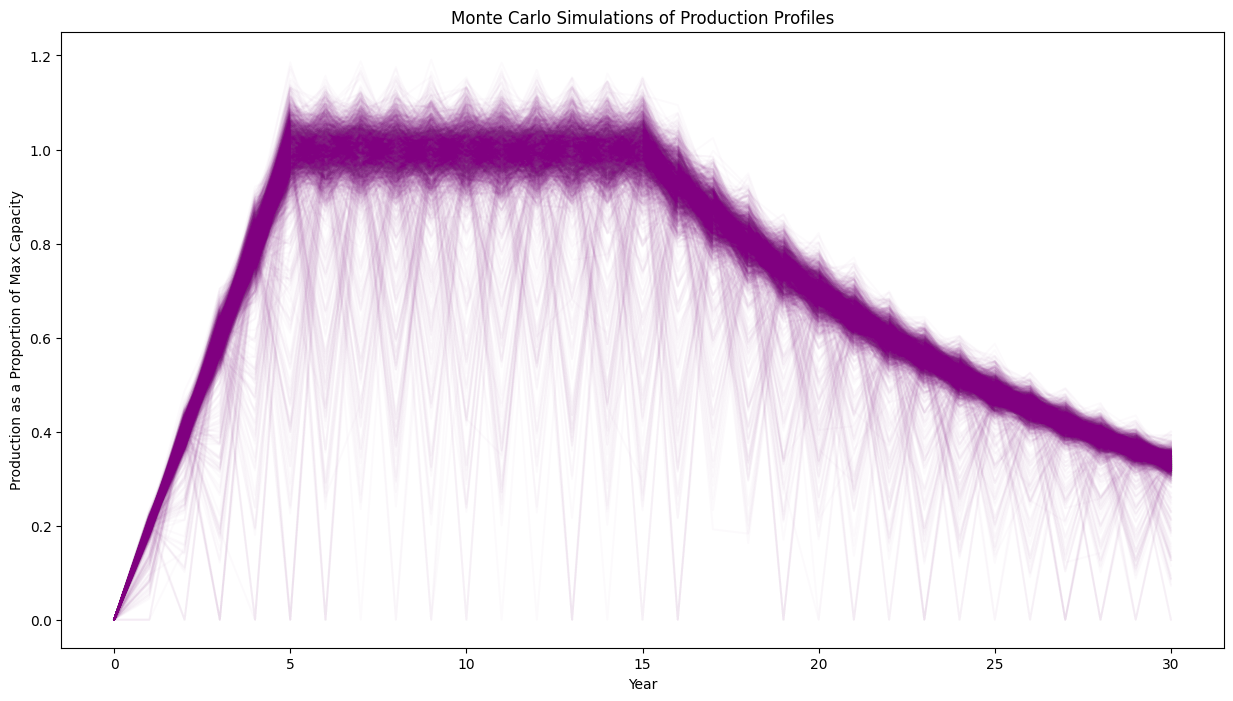

In [19]:
import matplotlib.pyplot as plt

# Running the Monte Carlo simulations
all_profiles = []
for _ in range(num_simulations):
    profile = apply_uncertainty_to_production_profile(production_profile)
    all_profiles.append(profile)

# Plotting all profiles
plt.figure(figsize=(15, 8))
for profile in all_profiles:
    plt.plot(profile, color='purple', alpha=0.02)  # Slightly transparent lines

plt.title('Monte Carlo Simulations of Production Profiles')
plt.xlabel('Year')
plt.ylabel('Production as a Proportion of Max Capacity')
plt.show()


In [22]:
# # Adjusting the color intensity to be strongest in the inner part and symmetrical around the median

# # Re-defining the colormap to make the inner part the strongest color
# def adjust_cmap(cmap, N=100):
#     return cmap(np.linspace(0.3, 1, N))

# adjusted_cmap_blues = adjust_cmap(cmap_blues)

# # Re-plotting with adjusted colormap
# plt.figure(figsize=(15, 8))

# # Below the median
# for i in range(50):
#     color = adjusted_cmap_blues[i]  # Normalizing the color map index
#     plt.fill_between(range(len(median_profile)), percentiles_below_median[i], percentiles_below_median[100 - i], color=color, alpha=0.1)

# # Above the median
# for i in range(50):
#     color = adjusted_cmap_blues[i]  # Normalizing the color map index
#     plt.fill_between(range(len(median_profile)), percentiles_above_median[i], percentiles_above_median[100 - i], color=color, alpha=0.1)

# # Plotting the median profile
# plt.plot(median_profile, color='black', label='Median Profile')

# # Customizing the plot
# plt.title('Symmetrically Color Coded Probabilities of Production Profiles (Adjusted Blues)')
# plt.xlabel('Year')
# plt.ylabel('Production as a Proportion of Max Capacity')
# plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), orientation='vertical', label='Probability Percentile')
# plt.legend()
# plt.show()



### Chartering Rates

In [23]:
pip install copulas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.1 MB/s eta 0:00:00


In [24]:
path = '/content/drive/MyDrive/Skole/Crude_Project/Ulstrup data - Oct 2023.xlsx'

df = pd.read_excel(path, sheet_name='Aframax')

In [25]:
# Create a new DataFrame
df_new = pd.DataFrame()
df_new['time'] = pd.to_datetime(df['time'])
df_new['spot_afra'] = df['spot_afra'].values
df_new['TC1_afra'] = df['TC1_afra'].values
df_new['TC5_afra'] = df['TC5_afra'].values

# Set the 'time' column as the index
df_new.set_index('time', inplace=True)

# remove all rows with NaN values
df_new = df_new.dropna()

In [26]:
from copulas.multivariate import GaussianMultivariate

# Fit a Gaussian copula to the data
chartering_rates_copula = GaussianMultivariate()
chartering_rates_copula.fit(df_new)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


,spot_afra,TC1_afra,TC5_afra
count,3000.00,3000.00,3000.00
mean,26681.45,23033.12,21244.91
std,19829.31,9727.19,4304.64
min,2824.49,13000.00,16461.37
25%,12268.25,14524.08,18113.19
50%,21535.48,19703.86,20009.63
75%,35487.06,29832.27,23053.66
max,197650.94,47703.39,53222.12


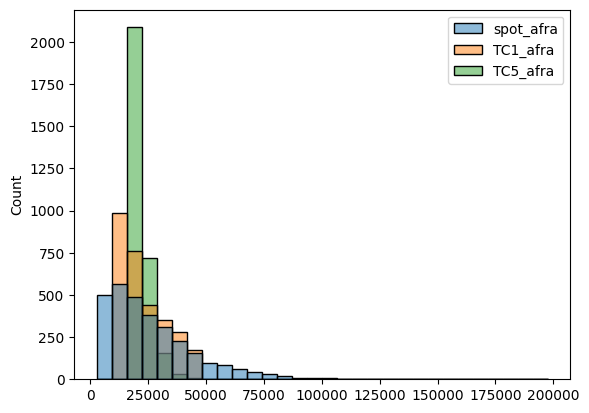

In [27]:
# TEST
# You can now sample from the copula or calculate statistics
sampled_rates = chartering_rates_copula.sample(3000)  # Generate 3000 samples

display(sampled_rates.describe())
sns.histplot(sampled_rates, bins=30)
plt.show()

In [28]:
upper_bound_spot = sampled_rates['spot_afra'].quantile(0.75)
lower_bound_spot = sampled_rates['spot_afra'].quantile(0.25)

upper_bound_TC1 = sampled_rates['TC1_afra'].quantile(0.75)
lower_bound_TC1 = sampled_rates['TC1_afra'].quantile(0.25)

upper_bound_TC5 = sampled_rates['TC5_afra'].quantile(0.75)
lower_bound_TC5 = sampled_rates['TC5_afra'].quantile(0.25)

### Fuel price

In [29]:
vlsfo = df['VLFSO_Rot'].dropna().values

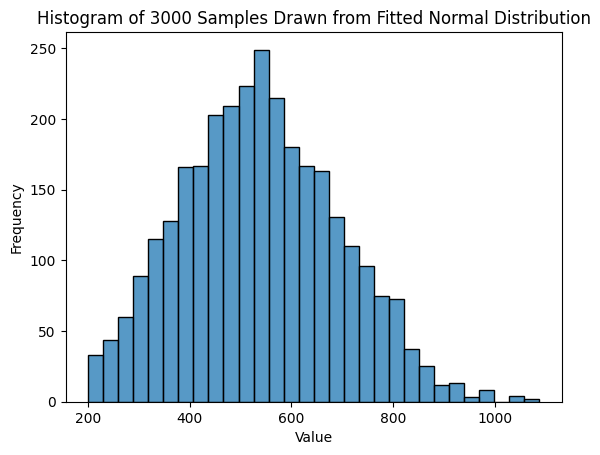

In [30]:
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt

# Assuming vlsfo is the data for which the normal distribution was fitted
# Fit the data to a normal distribution
mu, std = norm.fit(vlsfo)

# Define the lower and upper bounds for the distribution
lower, upper = 200, np.inf  # This ensures no negative values

# Calculate the parameters for the truncated normal distribution
a, b = (lower - mu) / std, (upper - mu) / std

# Draw samples from the truncated normal distribution
num_samples = 3000
sampled_vlsfo_price = truncnorm.rvs(a, b, loc=mu, scale=std, size=num_samples)

# Plotting the histogram of the sampled data
sns.histplot(sampled_vlsfo_price, bins=30)
plt.title('Histogram of 3000 Samples Drawn from Fitted Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()



### Port and Additional Charges

Sampled Port Charges: [519962.5772693446, 518230.04064482957, 710177.8781220638, 726760.657277063, 564285.9915135137, 431696.1475699955, 585772.8891632922, 525243.0956688821, 726845.5410289903, 475550.3992823862]


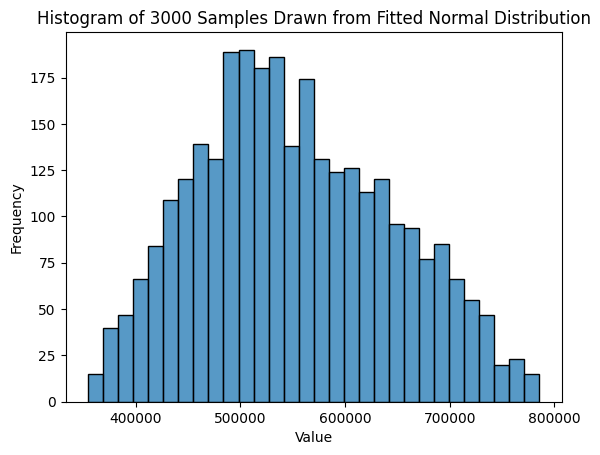

In [31]:
import numpy as np

def calculate_new_port_charges():
    lower_bound = 350000  # Lower limit of the distribution
    upper_bound = 800000  # Upper limit of the distribution
    mode = 500000  # Value with the highest probability

    # Draw a sample from the triangular distribution
    new_charge = np.random.triangular(lower_bound, mode, upper_bound)
    return new_charge

# Example Usage
num_samples = 3000
sampled_charges = [calculate_new_port_charges() for _ in range(num_samples)]

# Display first 10 sampled charges
print("Sampled Port Charges:", sampled_charges[:10])


# Plotting the histogram of the sampled data
sns.histplot(sampled_charges, bins=30)
plt.title('Histogram of 3000 Samples Drawn from Fitted Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [32]:
sampled_charges = pd.DataFrame(sampled_charges)
upper_bound_port_charges = sampled_charges.quantile(0.75)
lower_bound_port_charges = sampled_charges.quantile(0.25)

### Waiting Time

Sampled Total Times (days): [5.5984289381670065, 2.6815403173578067, 2.617196807518517, 3.8128038154979116, 3.145222675357182, 3.388210109371208, 2.2428914133871056, 4.661150824580217, 4.747934430867597, 4.511748450529925]


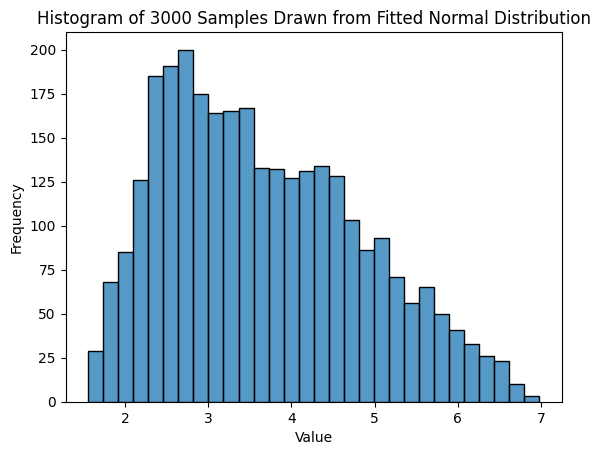

In [33]:
def calculate_port_and_waiting_time():
    min_time = 1.5  # in days
    max_time = 7  # in days
    most_likely_time = 2.5  # in days

    # Draw a sample from the triangular distribution
    total_time = np.random.triangular(min_time, most_likely_time, max_time)
    return total_time

# Example Usage
num_samples = 3000
sampled_port_and_waiting_time = [calculate_port_and_waiting_time() for _ in range(num_samples)]

# Display first 10 sampled total times
print("Sampled Total Times (days):", sampled_port_and_waiting_time[:10])

# Plotting the histogram of the sampled data
sns.histplot(sampled_port_and_waiting_time, bins=30)
plt.title('Histogram of 3000 Samples Drawn from Fitted Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


### Tornado Diagram

In [46]:
import pandas as pd

# Initialize the DataFrame
tornado_df = pd.DataFrame(columns=['Uncertainty', 'Base_Value', 'Lower_Bound', 'Upper_Bound', 'Performance_Lower', 'Performance_Upper'])

# Add data for each uncertainty

# Production
prod_df = pd.DataFrame({
    'Uncertainty': ['Production'],
    'Base_Value': [(flat_production_samples_df.mean())],
    'Lower_Bound': [(flat_production_samples_df.quantile(0.25))],
    'Upper_Bound': [(flat_production_samples_df.quantile(0.75))],
    'Performance_Lower': [None],
    'Performance_Upper': [None]
})

# Chartering Rates
chartering_rates_base = [sampled_rates[col].mean() for col in ['spot_afra', 'TC1_afra', 'TC5_afra']]
chartering_rates_lower = [lower_bound_spot, lower_bound_TC1, lower_bound_TC5]
chartering_rates_upper = [upper_bound_spot, upper_bound_TC1, upper_bound_TC5]

charter_df = pd.DataFrame({
    'Uncertainty': ['Chartering Rates'],
    'Base_Value': [[round(val) for val in chartering_rates_base]],  # Nested list to keep as a single entry
    'Lower_Bound': [[round(val) for val in chartering_rates_lower]],
    'Upper_Bound': [[round(val) for val in chartering_rates_upper]],
    'Performance_Lower': [None],
    'Performance_Upper': [None]
})

# Fuel Price
sampled_vlsfo_price = pd.DataFrame(sampled_vlsfo_price)

fuel_price_df = pd.DataFrame({
    'Uncertainty': ['Fuel Price'],
    'Base_Value': [round(sampled_vlsfo_price.mean())],
    'Lower_Bound': [round(sampled_vlsfo_price.quantile(0.25))],
    'Upper_Bound': [round(sampled_vlsfo_price.quantile(0.75))],
    'Performance_Lower': [None],
    'Performance_Upper': [None]
})

# Port and Waiting Time
sampled_port_and_waiting_time = pd.DataFrame(sampled_port_and_waiting_time)

port_waiting_df = pd.DataFrame({
    'Uncertainty': ['Port and Waiting Time'],
    'Base_Value': [(sampled_port_and_waiting_time.mean())],
    'Lower_Bound': [(sampled_port_and_waiting_time.quantile(0.25))],
    'Upper_Bound': [(sampled_port_and_waiting_time.quantile(0.75))],
    'Performance_Lower': [None],
    'Performance_Upper': [None]
})

# Port Fees and Additional Charges
sampled_port_charges = pd.DataFrame(sampled_charges)
port_charges_df = pd.DataFrame({
    'Uncertainty': ['Port Fees and Additional Charges'],
    'Base_Value': [round(sampled_port_charges.mean())],
    'Lower_Bound': [round(sampled_port_charges.quantile(0.25))],
    'Upper_Bound': [round(sampled_port_charges.quantile(0.75))],
    'Performance_Lower': [None],
    'Performance_Upper': [None]
})

# Concatenate all DataFrames
tornado_df = pd.concat([tornado_df, prod_df, charter_df, fuel_price_df, port_waiting_df, port_charges_df], ignore_index=True)

# Display the DataFrame
display(tornado_df)


,Uncertainty,Base_Value,Lower_Bound,Upper_Bound,Performance_Lower,Performance_Upper
0,Production,Production 0.98 dtype: float64,"Production 0.96 Name: 0.25, dtype: float64","Production 1.03 Name: 0.75, dtype: float64",None,None
1,Chartering Rates,"[26681, 23033, 21245]","[12268, 14524, 18113]","[35487, 29832, 23054]",None,None
2,Fuel Price,0 539.00 dtype: float64,"0 426.00 Name: 0.25, dtype: float64","0 644.00 Name: 0.75, dtype: float64",None,None
3,Port and Waiting Time,0 3.67 dtype: float64,"0 2.71 Name: 0.25, dtype: float64","0 4.50 Name: 0.75, dtype: float64",None,None
4,Port Fees and Additional Charges,0 552130.00 dtype: float64,"0 483834.00 Name: 0.25, dtype: float64","0 620976.00 Name: 0.75, dtype: float64",None,None


In [ ]:


distributions = {
    'fuel_price_vlsfo': {'type': 'normal', 'std_dev': 0.05},
    'port_charges': {'type': 'normal', 'std_dev': 0.05},
    'waiting_time': {'type': 'normal', 'std_dev': 0.05},
    'crude_oil_price': {'type': 'normal', 'std_dev': 0.05},
}



### TEST AND OTHER CODE


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

class MonteCarloModel(StaticModel):
    def __init__(self, df_variables, df_uncertainty, production_profile, num_simulations=1000):
        super().__init__(df_variables, df_uncertainty, production_profile)
        self.num_simulations = num_simulations
        # Define the distributions for uncertain parameters here
        # Example: self.spot_rate_distribution = norm(loc=self.fixed_spot, scale=1000)

    def run_simulation(self):
        # Store results of each simulation
        results = np.zeros(self.num_simulations)
        for sim in range(self.num_simulations):
            # Sample from distributions for uncertain parameters and update model attributes
            # Example: self.fixed_spot = self.spot_rate_distribution.rvs()

            # Run the static model's simulation
            profit_npv, cost_per_cargo_npv = super().run_case(decision_rule)

            # Store results
            results[sim] = profit_npv  # or any other metric of interest

        return results

    def aggregate_results(self, results):
        # Calculate statistical measures of the results
        mean_result = np.mean(results)
        std_deviation = np.std(results)
        confidence_interval = np.percentile(results, [2.5, 97.5])
        return mean_result, std_deviation, confidence_interval

    # Additional methods for visualization or further analysis can be added here

# Usage example
# Initialize the Monte Carlo model
mc_model = MonteCarloModel(df_variables, df_uncertainty, production_profile, num_simulations=1000)

# Run the Monte Carlo simulation
simulation_results = mc_model.run_simulation()

# Aggregate and analyze results
mean_result, std_deviation, confidence_interval = mc_model.aggregate_results(simulation_results)


In [ ]:
import plotly.graph_objects as go

# Example data
years = list(range(2000, 2021))  # Years from 2000 to 2020
values = [20, 15, 10, 5, 10, 15, 20, 25, 30, 35, 40, 35, 30, 25, 20, 15, 10, 5, 10, 15, 20]  # Example values for bar plot
image_counts = [2, 1, 3, 4, 1, 2, 2, 3, 1, 4, 3, 2, 1, 3, 4, 2, 1, 3, 2, 1, 2]  # Number of 'images' to represent under the timeline

# Create figure
fig = go.Figure()

# Add bar plot above the timeline
fig.add_trace(go.Bar(x=years, y=values, name='Values'))

# Add markers to represent images below the timeline
for i, year in enumerate(years):
    for j in range(image_counts[i]):
        fig.add_trace(go.Scatter(x=[year], y=[-j *5 - 5], mode='markers',
                                 marker_symbol='star', marker_size=10,
                                 marker_color='blue', showlegend=False))

# Update layout for a better view
fig.update_layout(
    yaxis=dict(
        range=[-max(image_counts) * 6, max(values)],
        showgrid=False
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=years,
        ticktext=[str(year) for year in years]
    ),
    title='Interactive Timeline with Bar Plot and Markers'
)

# Show the figure
fig.show()

In [ ]:
pip install dash